In [75]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(stringr)
library(DBI)
library(dbplyr)
options(repr.matrix.max.rows = 6)

# Predicting the Win Rate of Tennis Players  
<img align="left" src="https://images.unsplash.com/photo-1554068865-24cecd4e34b8?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8dGVubmlzfGVufDB8fDB8fA%3D%3D&ixlib=rb-1.2.1&auto=format&fit=crop&w=500&q=60" width="1000" />  

*Source: https://unsplash.com/photos/WqI-PbYugn4*

# Introduction<img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />   


### Background 

Tennis is a popular, competitive sport played around the world. In tennis, players gain points by hitting a tennis ball, across a net in the court, in such a way that their opponent is unable to hit it back without the ball bouncing twice. 
Tennis can be played in "singles" where there is only one person on each side of the net or "doubles" where there are teams of two. 
It can be played on a variety of surfaces such as grass, clay, or hard court (i.e. like a gym floor).

- Professional tennis players participate in large **tournaments** for ranks, prizes, and fame. 
- In a tournament, players advance to the next round by winning their **match** against an opponent. 
- To win a match, a player must win two (or three, depending on the tournament) **sets**. 
- A set is won by the player who wins six **games**.
- A game is won by the first player to reach four **points**

The association of tennis professionals, or ATP, organizes these tournaments and collects data on the players and the matches that take place.

### Our Question

Based on the career statistics of a tennis player, what will be their win rate?

### Our Dataset

We are using the "Game results for Top 500 Players from 2017-2019" dataset for our analysis. Each row in this dataset represents a match between two players. Each row contains player stats (e.g. age, height, rank) and match stats (break points, serve points, double faults etc.). We use group_by and summarize per player for this dataset to calculate the average stats for their career. Then, we can determine the relationship between player stats and win rate.

*Picture source: https://www.emojipng.com/preview/458725*

# Preliminary Exploratory Data Analysis <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />   


In [76]:
## the dataset can be read from the URL link:
atp_data_frame <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(atp_data_frame)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


In [77]:

# calculate player wins and mean match stats for winning matches
player_wins <- atp_data_frame %>%
    group_by(player_id = winner_id) %>%
    summarize(w_height = mean(winner_ht, na.rm =TRUE),
              w_breakpoint_saved_pct = mean(w_bpSaved/w_bpFaced, na.rm =TRUE),
              w_second_serve_win_pct = mean(w_2ndWon / w_svpt,na.rm =TRUE),
              w_df_pct = mean(w_df / w_SvGms,na.rm =TRUE),
              w_first_serve_pct = mean(w_1stWon / w_1stIn,na.rm =TRUE),
              w_first_serve_win_pct = mean(w_1stWon / w_svpt, na.rm = TRUE),
              n_wins = n(),
              mean_age_w  = mean(winner_age),
              mean_rank_points_w = mean(winner_rank_points),
              w_ace_point_pct = mean(w_ace/w_svpt,na.rm = TRUE)
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# calculate player losses and mean match stats for losing matches
player_lose <- atp_data_frame %>%
    group_by(player_id = loser_id) %>%
    summarize(l_height = mean(loser_ht, na.rm =TRUE),
              l_breakpoint_saved_pct = mean(l_bpSaved/l_bpFaced, na.rm =TRUE),
              l_second_serve_win_pct = mean(l_2ndWon / l_svpt,na.rm =TRUE),
              l_df_pct = mean(l_df / l_SvGms, na.rm =TRUE),
              l_first_serve_pct = mean(l_1stWon / l_1stIn,na.rm =TRUE),
              l_first_serve_win_pct = mean(l_1stWon / l_svpt, na.rm = TRUE),
              n_lose = n(),
              mean_age_l  = mean(loser_age),
              mean_rank_points_l = mean(loser_rank_points),
              l_ace_point_pct = mean(l_ace/l_svpt,na.rm = TRUE)
             ) %>%
    drop_na() %>%
    mutate(player_id = as.character(player_id))

# join datasets for wins and losses using unique player ids
player_join <- left_join(player_wins, player_lose, by = NULL, copy = TRUE)

# calculate career stats for all player matches
player_career <- player_join %>%
    mutate(height = (w_height + l_height)/2,
          breakpoint_saved_pct = (w_breakpoint_saved_pct+l_breakpoint_saved_pct)/2,
          second_serve_win_pct = (w_second_serve_win_pct+l_second_serve_win_pct)/2,
          df_pct = (w_df_pct+l_df_pct)/2,
          first_serve_pct = (w_first_serve_pct+l_first_serve_pct)/2,
          first_serve_win_pct = (w_first_serve_win_pct + l_first_serve_win_pct)/2,
          win_rate = (n_wins/(n_lose+n_wins)*100),
          age = (mean_age_w + mean_age_l) /2,
          mean_rank_points = (mean_rank_points_w + mean_rank_points_l)/2,
          ace_point_pct = (w_ace_point_pct+l_ace_point_pct)/2) %>%
    select(player_id,height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,first_serve_win_pct, win_rate,age,mean_rank_points,ace_point_pct) %>%
    drop_na()

player_career

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "player_id"



player_id,height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,first_serve_win_pct,win_rate,age,mean_rank_points,ace_point_pct
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100644,198,0.5592240,0.1700660,0.3238533,0.7351579,0.4788888,69.34673,21.15730,4281.6435,0.1112491
103333,208,0.7024075,0.1934502,0.3366579,0.8336761,0.5415601,41.02564,39.12084,962.8682,0.2309365
103819,185,0.6093525,0.2114465,0.1394469,0.7770562,0.4895284,84.17722,37.09069,6720.2910,0.1022566
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
106296,183,0.5769397,0.1768606,0.2695325,0.6743243,0.4253424,33.33333,25.12377,458.375,0.07423463
106298,185,0.6420310,0.2225114,0.2879338,0.7383816,0.4218095,58.08824,24.20236,1914.473,0.08959409
106401,193,0.6480872,0.1862049,0.2936494,0.7819567,0.5078608,62.71186,23.02092,1722.535,0.19922835


We have grouped each unique player's matches together and calculated the mean of several key stats, creating a sort of "career average" dataframe. Additionally, we have introduced a new stat, *win_rate*, which is found by dividing the number of times a player was in the winning column by the total amount of times that player appeared in the winner + loser columns. 

For each of the linear relationships we also show a correlation coefficient indicating the strength and direction of the relationship

In [78]:
# split the data set into training and testing set. The following exploratory data analysis uses only the training set
set.seed(20)
player_split <- initial_split(player_career, prop = 0.75, strata = win_rate)
player_train <- training(player_split)
player_test <- testing(player_split)

In [79]:
# exploratory data analysis table:

# the means of the predictor variables we plan to use in our analysis
exploratory_data_analysis_table <- player_train %>%
    select(-player_id) %>%
    map_df(mean, na.rm = TRUE)
exploratory_data_analysis_table


height,breakpoint_saved_pct,second_serve_win_pct,df_pct,first_serve_pct,first_serve_win_pct,win_rate,age,mean_rank_points,ace_point_pct
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
186.0253,0.5947108,0.1958433,0.2462061,0.7193289,0.44232,45.90908,30.0706,1208.705,0.07991921


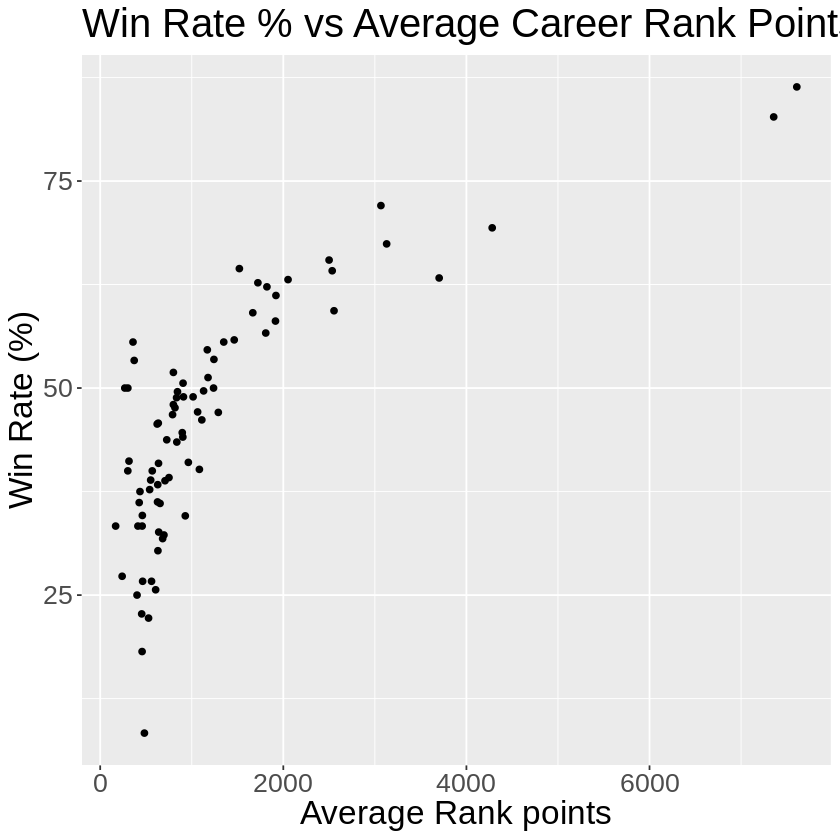

In [80]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_1 <- ggplot(player_train, aes(x = mean_rank_points,y = win_rate)) + 
    geom_point() +
    xlab("Average Rank points") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    ggtitle("Win Rate % vs Average Career Rank Points") 
exploratory_data_analysis_plot_1

1). We can see that there is a strong relationship between "average career rank points" and "win rate" is which is non-linear and positive. This sets up nicely for a KNN regression model.

In [1]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_2 <- ggplot(player_train, aes(x = df_pct,y=win_rate)) + 
    geom_point() +
    xlab("Average # of Double Faults per Serve Game") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs Average Double Fault Rate")
x <- select(player_train, df_pct)
y <- select(player_train, win_rate)
c_l_1 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_1
exploratory_data_analysis_plot_2

ERROR: Error in ggplot(player_train, aes(x = df_pct, y = win_rate)): could not find function "ggplot"


2). We can see that there is a weak relationship between “average double fault rate” and the “win rate” that is negative and linear.

,win_rate
age,-0.1175338


`geom_smooth()` using formula 'y ~ x'



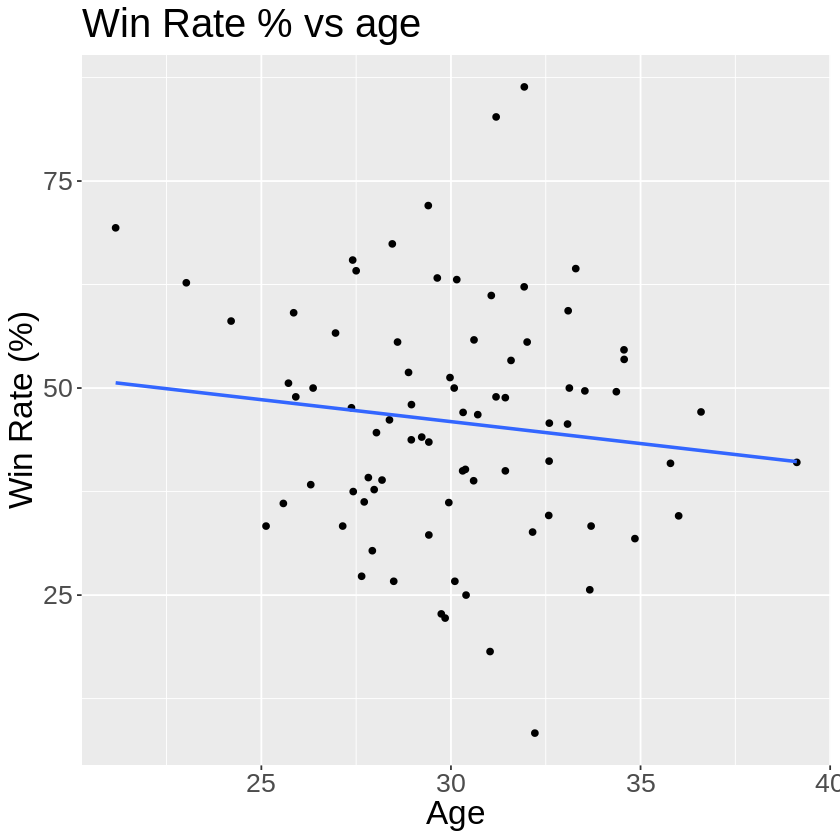

In [82]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_3 <- ggplot(player_train, aes(x = age,y=win_rate)) + 
    geom_point() +
    xlab("Age") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs Age")
x <- select(player_train, age)
y <- select(player_train, win_rate)
c_l_2 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_2
exploratory_data_analysis_plot_3

3). We can see that there is a weak relationship between “age” and “win rate” that is negative and linear.

,win_rate
first_serve_win_pct,0.2336128


`geom_smooth()` using formula 'y ~ x'



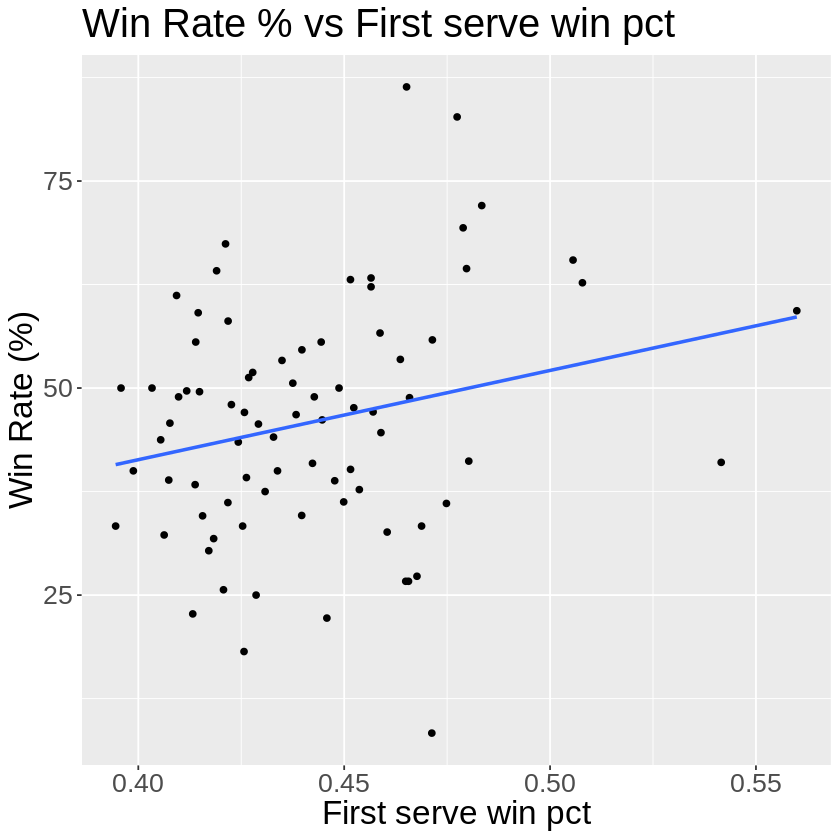

In [83]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_4 <- ggplot(player_train, aes(x = first_serve_win_pct,y=win_rate)) + 
    geom_point() +
    xlab("First Serve Win %") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs First Serve Win %")
x <- select(player_train, first_serve_win_pct)
y <- select(player_train, win_rate)
c_l_3 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_3
exploratory_data_analysis_plot_4

4). We see that there is a positive linear relationship between a player’s “first serve win percentage” and “win rate”.

,win_rate
ace_point_pct,0.1655874


`geom_smooth()` using formula 'y ~ x'



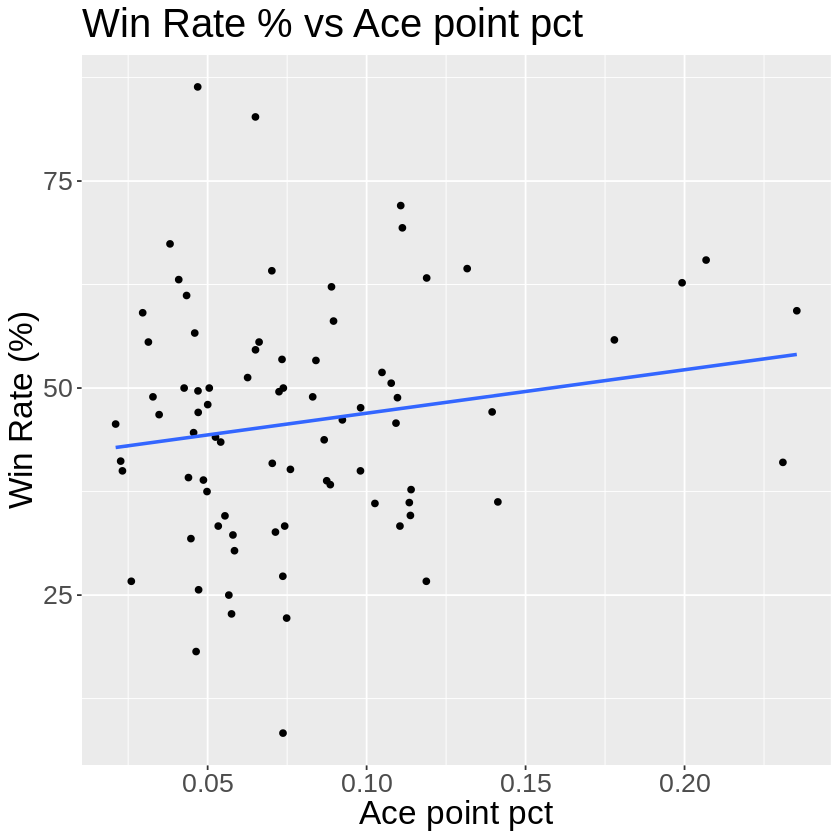

In [84]:
# exploratory data analysis plot:
exploratory_data_analysis_plot_5 <- ggplot(player_train, aes(x = ace_point_pct,y=win_rate)) + 
    geom_point() +
    xlab("Ace Point %") +
    ylab("Win Rate (%)") + 
    theme(text = element_text(size = 20)) + 
    geom_smooth(method = "lm", se = FALSE) +
    ggtitle("Win Rate % vs Ace point %")
x <- select(player_train, ace_point_pct)
y <- select(player_train, win_rate)
c_l_4 <- cor(x, y,  method = "pearson", use = "complete.obs")
c_l_4
exploratory_data_analysis_plot_5

5). We see that there is a positive linear relationship between “ace point %” and “win rate”.

# Methods <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" />  

There are many components involved in the game of tennis and that is reflected in the 50 columns of this raw data set. These variables contribute to whether a player wins or loses a match and affects that player's overall win rate. By mutating the data into nine predictors we can set a KNN regression model to predict a player's career win rate. The predictors include:


| Variable                        | Explanation                                                                                         |
|---------------------------------|-----------------------------------------------------------------------------------------------------|
| Age (years)                     | Older players will have sustained more injuries and be less fit.                                    |
| Height (cm)                     | Height can provide an advantage when serving.                                                       |
| Serve Points that were Aces (%) | Winning points on a serve indicates a strong serve.                                                 |
| First Serves (%)                | The ratio of "first serve points" to "first serves made in" means a player's serve is more accurate |
| First Serves Won (%)            | Strong and accurate first serves will lead to fewer double faults.                                  |
| Second Serves Won (%)           | Strong second serves means fewer lost points due to a slow serve.                                   |
| Double Faults per Game (ratio)  | Fewer double faults per game indicates accurate serving.                                            |
| Breakpoints Saved (%)           | Preventing breaks means a player wins the important points for winning the match                    |
| Rank Points                     | Awarded to players by the ATP for winning matches                                                   |

The KNN regression model will need to be trained, evaluated, and tuned with training and testing sets before predicting a win rate on a new player. By organizing a data set to keep track of both the K and RMSE (Root Mean Square Error) values calculated, we will be able to visualize how each predictor affects the player's win rate. We can then further analyze which combination of predicators, if any, will yield the lowest test error resulting in a better ability to predict a player's win rate. 

# Expected outcomes and significance <img align="left" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDixQBw3HoqS_gnC9xVtHO-5NrnS1eQ91N3w&usqp=CAU" width="35" /> 

We expect that the estimated win rate will reflect the respective career stats of the player. For example, if they have impressive stats, such as a high "breakpoint save percentage" and high "rank points", then their win rate will be high. Conversely, if our player has poor stats, their win rate will reflect this and be lower. 

Predicting the approximate win rate of a given player could be useful in a number of applications. For one, it could be used to get a sense of how the player will perform in the future. In other words, with the knowledge of their win rate, one can make a rough estimate of a player's chances in an upcoming tournament or season. Additionally, as the win rate is based on existing stats, it can be used to provide a clearer estimate of the result of a head-to-head match. 

This analysis could also prompt further questions:
 - Are there stats not included in the dataset that could improve the effectiveness of the model?
 - Do certain stats influence win rate more, and if so, is there a better weight function to use in the regression engine?

